In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 23.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=4cf841a04ae5e8207bda760c0281855e92770fa4abafdaef058f8831f188de04
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [4]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder.appName("Bitcoin_Price_Exploration").getOrCreate()

# Load the CSV file into a Spark DataFrame
bitcoin_df = spark.read.csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", header=True, inferSchema=True)

# Print the schema of the DataFrame
bitcoin_df.printSchema()

# Show the first 10 rows of the DataFrame
bitcoin_df.show(10)

# Get summary statistics for each variable in the DataFrame
bitcoin_df.describe().show()

# Check the number of rows and columns in the DataFrame
print("Number of rows: ", bitcoin_df.count())
print("Number of columns: ", len(bitcoin_df.columns))


root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)

+----------+-----------+-----------+-----------+-----------+------------+-----------------+--------------+
| Timestamp|       Open|       High|        Low|      Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+-----------+-----------+-----------+-----------+------------+-----------------+--------------+
|1325317920|       4.39|       4.39|       4.39|       4.39|  0.45558087|      2.000000019|          4.39|
|1325317980|2632.205515|2634.345198|2629.790035|2632.185289| 10.80028305|        24061.405|   2632.043084|
|1325318040|2632.205515|2634.345198|2629.790035|2632.185289| 10.80028305|        24061.405|   2632.043084|
|1325318100|2632.205515|263

In [5]:
# Import necessary libraries
from pyspark.sql.functions import isnan, when, count

# Count the number of missing values in each column
missing_count = bitcoin_df.select([count(when(isnan(c) | bitcoin_df[c].isNull(), c)).alias(c) for c in bitcoin_df.columns])
missing_count.show()




+---------+----+----+---+-----+------------+-----------------+--------------+
|Timestamp|Open|High|Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+---------+----+----+---+-----+------------+-----------------+--------------+
|        0|   0|   0|  0|    0|           0|                0|             0|
+---------+----+----+---+-----+------------+-----------------+--------------+



In [6]:
from pyspark.sql.functions import from_unixtime, year, month, quarter
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import mean

In [7]:
from pyspark.sql.functions import date_format

bitcoin_df = bitcoin_df.withColumn("Timestamp", bitcoin_df["Timestamp"].cast(TimestampType()))
bitcoin_df = bitcoin_df.withColumn("Timestamp", date_format("Timestamp", "yyyy-MM-dd HH:mm:ss").cast(TimestampType()))


In [8]:
bitcoin_df_daily = bitcoin_df.groupBy("Timestamp").agg(mean("Weighted_Price").alias("Weighted_Price")).orderBy("Timestamp")
bitcoin_df_monthly = bitcoin_df.groupBy(year("Timestamp"), month("Timestamp")).agg(mean("Weighted_Price").alias("Weighted_Price")).orderBy("year(Timestamp)", "month(Timestamp)")
bitcoin_df_quarterly = bitcoin_df.groupBy(year("Timestamp"), quarter("Timestamp")).agg(mean("Weighted_Price").alias("Weighted_Price")).orderBy("year(Timestamp)", "quarter(Timestamp)")
bitcoin_df_yearly = bitcoin_df.groupBy(year("Timestamp")).agg(mean("Weighted_Price").alias("Weighted_Price")).orderBy("year(Timestamp)")


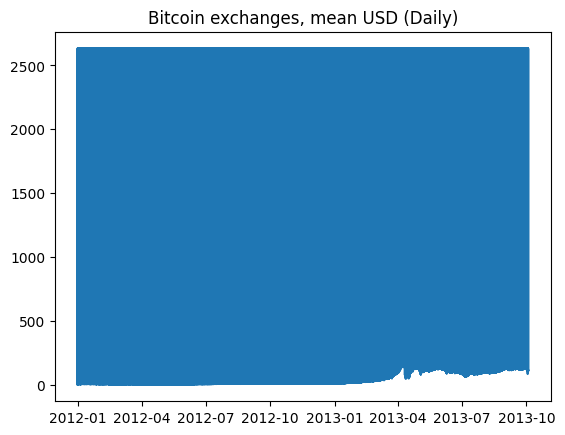

In [10]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
bitcoin_df_daily_pd = bitcoin_df_daily.toPandas()
bitcoin_df_monthly_pd = bitcoin_df_monthly.toPandas()
bitcoin_df_quarterly_pd = bitcoin_df_quarterly.toPandas()
bitcoin_df_yearly_pd = bitcoin_df_yearly.toPandas()

# Plot the daily data
plt.plot(bitcoin_df_daily_pd.Timestamp, bitcoin_df_daily_pd.Weighted_Price)
plt.title("Bitcoin exchanges, mean USD (Daily)")
plt.show()




In [11]:
# Convert the Spark DataFrame to a Pandas DataFrame
bitcoin_df_monthly_pd = bitcoin_df_monthly.toPandas()

# Check the column names of the DataFrame
print(bitcoin_df_monthly_pd.columns)


Index(['year(Timestamp)', 'month(Timestamp)', 'Weighted_Price'], dtype='object')


In [19]:
# Convert the Spark DataFrame to a Pandas DataFrame
bitcoin_df_quarterly_pd = bitcoin_df_quarterly.toPandas()

# Check the column names of the DataFrame
print(bitcoin_df_quarterly_pd.columns)

bitcoin_df_quarterly_pd["YearQuarter"] = bitcoin_df_quarterly_pd["year(Timestamp)"].map(str) + "-Q" + bitcoin_df_quarterly_pd["quarter(Timestamp)"].map(str)



Index(['year(Timestamp)', 'quarter(Timestamp)', 'Weighted_Price'], dtype='object')


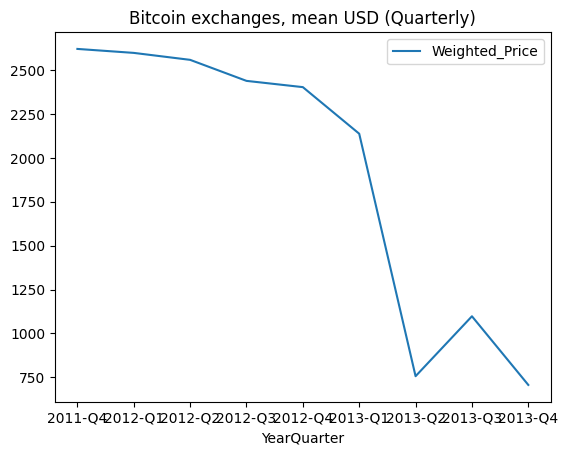

In [20]:
bitcoin_df_quarterly_pd.plot(x="YearQuarter", y="Weighted_Price")
plt.title("Bitcoin exchanges, mean USD (Quarterly)")
plt.show()


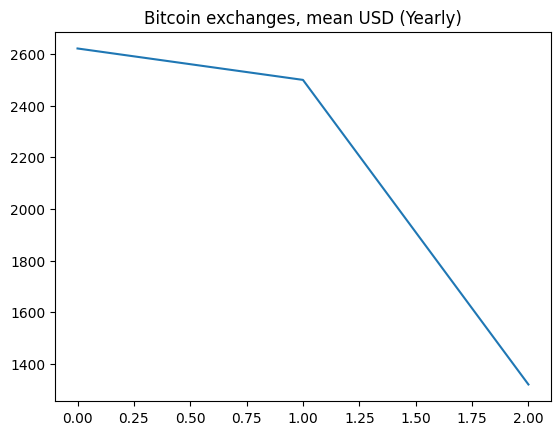

In [21]:
bitcoin_df_yearly_pd = bitcoin_df_yearly_pd.reset_index()
plt.plot(bitcoin_df_yearly_pd["index"], bitcoin_df_yearly_pd["Weighted_Price"])
plt.title("Bitcoin exchanges, mean USD (Yearly)")
plt.show()


ARIMA on Monthly basis

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         Weighted_Price   No. Observations:                   23
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -151.507
Date:                Fri, 31 Mar 2023   AIC                            313.013
Time:                        22:43:49   BIC                            318.468
Sample:                             0   HQIC                           314.298
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1794      0.445     -2.648      0.008      -2.052      -0.306
ar.L2         -0.1798      0.495     -0.364      0.716      -1.149       0.789
ma.L1          1.9850      0.526      3.772      0.0

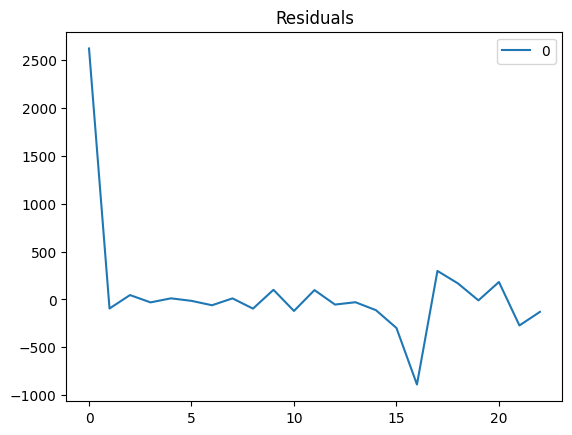

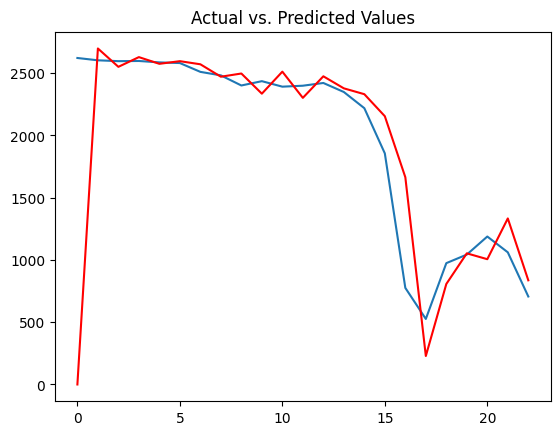

In [23]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model parameters
p = 2
d = 1
q = 2

# Fit the ARIMA model to the data
model = ARIMA(bitcoin_df_monthly_pd.Weighted_Price, order=(p, d, q))
results = model.fit()

# Print the model summary
print(results.summary())

# Plot the residuals
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.title("Residuals")
plt.show()

# Plot the actual vs. predicted values
predictions = pd.Series(results.fittedvalues, index=bitcoin_df_monthly_pd.index)
plt.plot(bitcoin_df_monthly_pd.Weighted_Price)
plt.plot(predictions, color="red")
plt.title("Actual vs. Predicted Values")
plt.show()
